In [65]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from esda.moran import Moran
from libpysal.weights import lat2W
from esda.moran import Moran_Local
from scipy.ndimage import label
from sklearn.cluster import DBSCAN
from scipy.ndimage import convolve

import cartopy.crs as ccrs
import cartopy.feature as cfeature

ds = xr.open_dataset("../../NC/compare.nc") 

In [66]:
def draw_map(data2d, lons, lats, cmap, vmin, vmax, title, outfile):
    lon2d, lat2d = np.meshgrid(lons, lats)

    plt.figure(figsize=(14, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # --- Basemap ---
    ax.set_global()
    ax.coastlines(color='black', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='gray')
    ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
    ax.add_feature(cfeature.OCEAN, facecolor='white')

    # --- Heatmap ---
    img = ax.pcolormesh(
        lon2d, lat2d, data2d,
        cmap=cmap,
        vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree()
    )
    plt.colorbar(img, ax=ax, shrink=0.6)
    plt.title(title)
    plt.savefig(outfile, dpi=500, bbox_inches='tight')
    plt.show()

In [67]:
def get_diff_v(ds, name, time):
    # 构造变量名
    var_basin  = f"basin_{name}"
    var_region = f"region_{name}"

    # 取该年数据
    da_basin  = ds[var_basin].sel(time=time)
    da_region = ds[var_region].sel(time=time)

    # 差值
    diff = da_region - da_basin

    # 有效区域 mask（至少一个 > 0）
    mask = (da_basin > 0) | (da_region > 0)
    diff_v = diff.where(mask)

    return diff_v

In [68]:
def get_quar(diff_v):
    vals = diff_v.values.flatten()
    vals = vals[~np.isnan(vals)]

    Q1     = np.percentile(vals, 25)
    Q3     = np.percentile(vals, 75)
    high = diff_v.where(diff_v > Q3)
    low  = diff_v.where(diff_v < Q1)
    return high,low

In [69]:
def run_lisa(diff_v,p_value):
    
    dv = diff_v.squeeze()
    nlat, nlon = dv.shape
    
    # 构建全局邻接权重
    w = lat2W(nlat, nlon)
    w.transform = 'r'

    # flatten 并填补 NaN（不能删掉）
    y = dv.fillna(0).values.flatten()
    lisa = Moran_Local(y, w, permutations=99)

    # reshape 回二维
    q = lisa.q.reshape(nlat, nlon)
    p = lisa.p_sim.reshape(nlat, nlon)
    # HH = (q == 1) & (p < p_value)
    # LL = (q == 3) & (p < p_value)
    HH = ((q == 1) | (q == 4)) & (p < p_value)   # High 类
    LL = ((q == 3) | (q == 2)) & (p < p_value)   # Low 类

    cluster_map = np.zeros_like(q)
    cluster_map[HH] = 1
    cluster_map[LL] = -1

    return cluster_map, q, p

In [70]:
# def filter_small_clusters(cluster_map, min_size=50):

    # mask = (cluster_map != 0)

    # # 连通域标记（True区域）
    # labeled, num = label(mask)

    # # 输出
    # filtered = np.zeros_like(cluster_map)

    # for lab in range(1, num + 1):
    #     area = np.sum(labeled == lab)

    #     if area >= min_size:
    #         # 把原来 cluster_map 的值（1 或 -1）传回来
    #         filtered[labeled == lab] = cluster_map[labeled == lab]

def filter_small_clusters(cluster_map, threshold=10,shape=7):
    mask = (cluster_map != 0).astype(int)

    # 定义卷积核
    kernel = np.ones((shape,shape), dtype=int)

    # 计算每个点周围非零点个数
    neighbor_count = convolve(mask, kernel, mode='constant', cval=0)

    # 保留邻域≥threshold 的点
    keep = neighbor_count >= threshold

    filtered = np.zeros_like(cluster_map)
    filtered[keep] = cluster_map[keep]
    return filtered

In [71]:
def run_dbscan_diff(diff_v,eps_km=100, min_samples=30):
    """
    diff_v: xarray.DataArray 或 numpy array, shape = (360,720)
    eps_km: DBSCAN 半径，单位公里（100km 是常用尺度）
    min_samples: 聚类最小点数（类似 min_size）
    """

    dv = diff_v.squeeze().values  # (360,720)

    lats = diff_v.lat.values
    lons = diff_v.lon.values
    nlat, nlon = dv.shape

    # 把二维网格展开
    LON, LAT = np.meshgrid(lons, lats)

    X = np.column_stack([LAT.flatten(), LON.flatten()])
    y = dv.flatten()

    # 只对差值大的区域聚类 (可改阈值)
    mask = np.abs(y) > 0.05          # 门槛值，你可以调
    X_sub = X[mask]
    y_sub = y[mask]

    # DBSCAN 用球面距离：转换成弧度
    X_rad = np.radians(X_sub)

    # 球面距离 eps → 弧度
    eps = eps_km / 6371.0   # km 转换成角距离

    db = DBSCAN(eps=eps, min_samples=min_samples, metric='haversine')
    labels = db.fit_predict(X_rad)

    # 构建输出图（360×720）
    cluster_map = np.full(dv.shape, np.nan)
    cluster_map.flat[mask] = labels
    
    return cluster_map, labels, X_sub, y_sub,eps_km

In [72]:
# def plot_on_map(filtered,original, diff_v,name,year,index,mode):
#     if mode == "lisa":

#         #filtered---
#         lons = diff_v.lon.values
#         lats = diff_v.lat.values
#         lon2d, lat2d = np.meshgrid(lons, lats)
#         plt.figure(figsize=(14,7))
#         # 设置地图投影（PlateCarree = 标准经纬度）
#         ax = plt.axes(projection=ccrs.PlateCarree())
#         ax.set_global()
#         # 底图：海岸线、陆地、国界线等
#         ax.coastlines(color='black', linewidth=1)
#         ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='gray')
#         ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
#         ax.add_feature(cfeature.OCEAN, facecolor='white')
#         # 热点图：只画红（1）和蓝（-1）
#         img = ax.pcolormesh(
#             lon2d, lat2d, filtered,
#             cmap='bwr', vmin=-1, vmax=1,
#             transform=ccrs.PlateCarree()
#         )
#         plt.colorbar(img, ax=ax, shrink=0.6, label="LISA cluster")
#         plt.title(f"LISA Hotspots (Red) / Coldspots (Blue) of {name} in {year} with p={index} filtered", fontsize=14)
#         plt.savefig(f"../../plot/analysis/lisa/LISA_{name}_{year}_p={index}_filtered4.png", dpi=500, bbox_inches='tight')
#         plt.show()

#         # original---
#         lons = diff_v.lon.values
#         lats = diff_v.lat.values
#         lon2d, lat2d = np.meshgrid(lons, lats)
#         plt.figure(figsize=(14,7))
#         ax = plt.axes(projection=ccrs.PlateCarree())
#         ax.set_global()
#         ax.coastlines(color='black', linewidth=1)
#         ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='gray')
#         ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
#         ax.add_feature(cfeature.OCEAN, facecolor='white')
#         img = ax.pcolormesh(
#             lon2d, lat2d, original,
#             cmap='bwr', vmin=-1, vmax=1,
#             transform=ccrs.PlateCarree())
#         plt.colorbar(img, ax=ax, shrink=0.6, label="LISA cluster")
#         plt.title(f"LISA Hotspots (Red) / Coldspots (Blue) of {name} in {year} with p={index} original", fontsize=14)
#         plt.savefig(f"../../plot/analysis/lisa/LISA_{name}_{year}_p={index}_original4.png", dpi=500, bbox_inches='tight')
#         plt.show()


#     elif mode == "dbscan":
#         lons = diff_v.lon.values
#         lats = diff_v.lat.values
#         lon2d, lat2d = np.meshgrid(lons, lats)
#         plt.figure(figsize=(14,7))
#         ax = plt.axes(projection=ccrs.PlateCarree())
#         ax.set_global()
#         ax.coastlines(color='black', linewidth=1)
#         ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='gray')
#         ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
#         ax.add_feature(cfeature.OCEAN, facecolor='white')
#         img = ax.pcolormesh(
#             lon2d, lat2d, filtered,
#             cmap='tab20',
#             transform=ccrs.PlateCarree()
#         )
#         plt.colorbar(img, ax=ax, shrink=0.6, label="Cluster ID")
#         plt.title("DBSCAN Clusters on diff_v")
#         plt.savefig(f"../../plot/analysis/lisa/DBSCAN_{name}_{year}_eps={index}.png", dpi=500, bbox_inches='tight')


In [73]:
def plot_on_map(filtered, original, diff_v, name, year, index, mode):

    lons = diff_v.lon.values
    lats = diff_v.lat.values

    if mode == "lisa":
        # -- 图1：filtered
        draw_map(
            data2d=filtered,
            lons=lons, lats=lats,
            cmap='bwr',
            vmin=-1, vmax=1,
            title=f"LISA Hotspots/Coldspots of {name} {year} p={index} (filtered)",
            outfile=f"../../plot/analysis/lisa/LISA_{name}_{year}_p={index}_filtered4.png"
        )

        # -- 图2：original
        draw_map(
            data2d=original,
            lons=lons, lats=lats,
            cmap='bwr',
            vmin=-1, vmax=1,
            title=f"LISA Hotspots/Coldspots of {name} {year} p={index} (original)",
            outfile=f"../../plot/analysis/lisa/LISA_{name}_{year}_p={index}_original4.png"
        )

    elif mode == "dbscan":
        draw_map(
            data2d=filtered,
            lons=lons, lats=lats,
            cmap='tab20',
            vmin=None, vmax=None,   # DBSCAN 不需要固定范围
            title=f"DBSCAN Clusters eps={index} on {name} {year}",
            outfile=f"../../plot/analysis/lisa/DBSCAN_{name}_{year}_eps={index}.png"
        )


In [74]:
# 前置计算（输入年份和项目）

years = list(range(2010, 2101, 10))   # 2010,2020,...,2100
years.insert(0, 2005)
names = ["agri","forest","grassland"]

year = "2100"
name = "agri"
time =f"{year}-01-01"

diff_v= get_diff_v(ds, name, time)
high,low = get_quar(diff_v)


In [75]:
# # 计算地图差值的控件自相关Moran's I
# arr = diff_v.fillna(0).values.flatten()

# nlat = diff_v.shape[0]
# nlon = diff_v.shape[1]
# # 构建空间权重（基于邻居关系）
# w = lat2W(nlat, nlon)
# w.transform = 'r'

# # Moran’s I
# mi = Moran(arr, w)

# print("Moran's I =", mi.I)
# print("p-value =", mi.p_sim)

In [ ]:
p_value = 0.015
cluster_map, q, p = run_lisa(diff_v,p_value)
lisafiltered=filter_small_clusters(cluster_map, threshold=10,shape=7)
plot_on_map(lisafiltered,cluster_map, diff_v,name,year,p_value,"lisa")

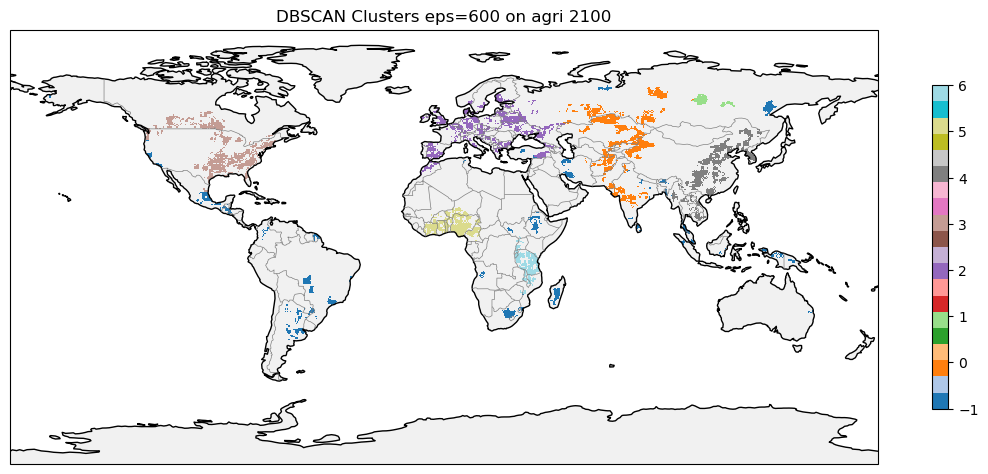

In [ ]:
eps_km = 600
mode = "dbscan"

if mode =="dbscan":
    mask = (lisafiltered != 0)
    diff_v_lisa = diff_v.where(mask)
    filtered,_,_,_,eps_km = run_dbscan_diff(diff_v_lisa, eps_km=eps_km, min_samples=80)
    
plot_on_map(filtered,cluster_map, diff_v,name,year,eps_km,mode)

### 分析流程总结（简洁版）

1. 读取 compare.nc 数据集  
   - 载入所有流域版与区域版的土地利用数据。

2. 计算差值 diff_v（region − basin）  
   - 得到每个格网的土地利用差异，并用 mask 去掉无效区域。

3. 计算四分位数（Q1、Q3）  
   - 标记差值特别高和特别低的格网（用于辅助理解）。

4. 运行 LISA 局部空间自相关  
   - 找到空间上显著聚集的 hotspot（增）和 coldspot（减）区域。

5. 根据 p-value 过滤显著热点和冷点  
   - 得到 cluster_map（1 = hotspot, -1 = coldspot, 0 = 不显著）。

6. 使用邻域卷积进行平滑过滤  
   - 去掉孤立点，只保留周围一定数量都有值的热点区域（lisafiltered）。

7. 用 LISA 过滤后的区域作为 mask  
   - 在 diff_v 上只保留显著区域，准备做聚类。

8. 运行 DBSCAN 空间聚类  
   - 基于地理距离（km），把显著区域进一步聚成大型空间簇。

9. 可视化所有结果  
   - 绘制 LISA 原图、LISA 过滤图、DBSCAN 聚类图。

### 分析フローまとめ（簡潔版）

1. compare.nc データの読み込み  
   - 流域版・地域版の土地利用データを読み込む。

2. 差分 diff_v（region − basin）の計算  
   - 各グリッドの土地利用差を求め、無効値をマスクする。

3. 四分位数（Q1・Q3）の計算  
   - 差が特に大きい／小さいグリッドを把握するための補助処理。

4. LISA（局所空間自己相関）の実行  
   - 空間的に有意なホットスポット／コールドスポットを検出。

5. p値による有意点の抽出  
   - cluster_map を作成（1 = hotspot, -1 = coldspot, 0 = 非有意）。

6. 近傍の畳み込みフィルタで平滑化  
   - 孤立点を除去し、連続した有意領域のみ残す（lisafiltered）。

7. LISA フィルタ後の領域を mask として使用  
   - diff_v から有意領域のみ抽出し、クラスタリングの対象にする。

8. DBSCAN の実行  
   - 地理的距離（km）に基づき、有意領域を大きなクラスタに分類。

9. 結果の可視化  
   - LISA 原図、LISA フィルタ図、DBSCAN 図をそれぞれ描画。
